In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Gesture Recognition Training 

In [2]:
import s3fs
import pandas as pd
import numpy as np
import scipy.stats
import time
import multiprocessing as mp
import json
import random
import os
import random
import matplotlib.pyplot as plt
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
output_notebook()

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [3]:
# Redundent Random seed setting to ensure reproducible results  
random.seed(314)
np.random.seed(314)
tf.set_random_seed(314)

In [4]:
def read_data_into_dataframe(fs,gesture_paths):
    
    examples = []
    for file in gesture_paths:
        with fs.open(file) as f:
            opened_file = json.loads(f.read())
        
        examples.append(opened_file)
    
    examples = pd.io.json.json_normalize(examples)
    
    return examples 

In [5]:
path_to_data = "cchase-rh-demo-4/training-data"
fs = s3fs.S3FileSystem()
list_of_gesture_paths = fs.walk(path_to_data)
then = time.time()
Data = read_data_into_dataframe(fs,list_of_gesture_paths)
print((time.time()-then)/60,"minutes")
print(len(Data), "records read...")

1.9914133906364442 minutes
849 records read...


In [6]:
def get_acceleration_data(df):
    re_arranged = []

    for row_index in range(len(Data)):

        x = [i[0] for i in df.iloc[row_index].motion]
        y = [i[1] for i in df.iloc[row_index].motion]
        z = [i[2] for i in df.iloc[row_index].motion]
        gesture = df.iloc[row_index].gesture

        entry = [x,y,z,gesture]
        re_arranged.append(entry)

    return pd.DataFrame(re_arranged, columns=["x","y","z","gesture"])
    

In [7]:
Acceleration_Data =  get_acceleration_data(Data)

In [8]:
def featurize(df_row, bins, columns):
    

    dimension_names = columns
    features = {}
    
    for ts, dim in zip(df_row,dimension_names):
        
        mean = np.mean(ts)
        median = np.median(ts)
        std = np.std(ts)
        length = len(ts)
        kurtosis = scipy.stats.kurtosis(ts)

        n, b = np.histogram(ts, 10)
        n = np.array(n)/float(np.sum(n)) #normalize i.e. fraction of entries in each bin

        if median == 0: 
            features[f'{dim}_mean_over_median'] =  0 #dimensionless            
            features[f'{dim}_std_over_median'] =  0 #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition
    

        else: 
            features[f'{dim}_mean_over_median'] =  mean/median #dimensionless            
            features[f'{dim}_std_over_median'] = std/median #dimensionless            
            features[f'{dim}_length'] = length
            features[f'{dim}_kurtosis'] = kurtosis #already dimensionless by definition


        for i, val in enumerate(n):
            features[f'{dim}_binfrac_{i}'] = val


        # new feature:
        midpoint = length//2
        ts_before = ts[:midpoint]
        ts_after = ts[midpoint:]

        mean_before = np.mean(ts_before) 
        mean_after = np.mean(ts_after)

        features[f'{dim}_mean_over_median_before'] = mean_before/median
        features[f'{dim}_mean_over_median_after'] = mean_after/median

        if length > 10:
            amp = np.fft.fft(ts)
            freq = np.fft.fftfreq(amp.size, 0.16)
            a_p = abs(amp.real[:1+len(amp)//2])
            f_p = freq[:1+len(freq)//2]

            max_power_index = np.argmax(abs(a_p[3:]))+3
            features[f'{dim}_max_power'] = abs(a_p[max_power_index])
            features[f'{dim}_period'] = f_p[max_power_index]
        else:
            features[f'{dim}_max_power'] = 0
            features[f'{dim}_period'] = 0


    features['label'] = df_row.gesture

    return features

In [9]:
then = time.time()
examples = [] 
b = np.arange(1,100,10)
columns = ["x","y","z"]
for i in Acceleration_Data.index:
    example = featurize(Acceleration_Data.iloc[i], b,columns)
    examples.append(example)
    
print((time.time()-then)/60,"minutes")
    

0.026206604639689126 minutes


In [10]:
df = pd.DataFrame(examples)

In [11]:
df = df[df["x_length"] > 200]
df = df.dropna()

In [12]:
train_df, test_df = train_test_split(df, train_size=0.75)

print(f'train size = {train_df.shape}')
print(f'test size = {test_df.shape}')

print(train_df['label'].value_counts())
print(test_df['label'].value_counts())

train size = (598, 55)
test size = (200, 55)
roll             114
draw-circle      103
draw-triangle    102
shake            100
fever             93
floss             86
Name: label, dtype: int64
shake            41
fever            37
draw-triangle    34
roll             32
floss            29
draw-circle      27
Name: label, dtype: int64


In [13]:
train_label = np.array(train_df['label'])
test_label = np.array(test_df['label'])

label_encoder = LabelEncoder()
one_hot_encoder = OneHotEncoder(sparse=False,categories='auto')

train_integer = label_encoder.fit_transform(train_label)
train_onehot = one_hot_encoder.fit_transform(train_integer.reshape(len(train_integer), 1))

test_integer = label_encoder.transform(test_label)
test_onehot = one_hot_encoder.transform(test_integer.reshape(len(test_integer), 1))

In [14]:
model_1 = keras.Sequential([
    keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(54,)),
    keras.layers.Dense(6, activation=tf.nn.log_softmax)
]) 

In [15]:
adm = tf.train.AdamOptimizer(learning_rate=1e-3)
model_1.compile(optimizer=adm, 
              loss=tf.losses.softmax_cross_entropy,
              metrics=['accuracy'])


In [16]:
history = model_1.fit( train_df.drop('label', axis=1), train_onehot, epochs=5000, verbose=1)

Epoch 1/5000
598/598 [==============================] - 0s 192us/step - loss: 285.6449 - acc: 0.1605
Epoch 2/5000
598/598 [==============================] - 0s 24us/step - loss: 152.9069 - acc: 0.1488
Epoch 3/5000
598/598 [==============================] - 0s 24us/step - loss: 70.9395 - acc: 0.2341
Epoch 4/5000
598/598 [==============================] - 0s 25us/step - loss: 41.3944 - acc: 0.3177
Epoch 5/5000
598/598 [==============================] - 0s 27us/step - loss: 29.9481 - acc: 0.3528
Epoch 6/5000
598/598 [==============================] - 0s 26us/step - loss: 22.5175 - acc: 0.3829
Epoch 7/5000
598/598 [==============================] - 0s 26us/step - loss: 17.3561 - acc: 0.4047
Epoch 8/5000
598/598 [==============================] - 0s 26us/step - loss: 13.4078 - acc: 0.4247
Epoch 9/5000
598/598 [==============================] - 0s 25us/step - loss: 11.6222 - acc: 0.4097
Epoch 10/5000
598/598 [==============================] - 0s 27us/step - loss: 10.6417 - acc: 0.4197
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 1.7120 - acc: 0.5669
Epoch 84/5000
598/598 [==============================] - 0s 29us/step - loss: 1.6159 - acc: 0.5803
Epoch 85/5000
598/598 [==============================] - 0s 25us/step - loss: 1.8300 - acc: 0.5535
Epoch 86/5000
598/598 [==============================] - 0s 25us/step - loss: 1.6065 - acc: 0.5702
Epoch 87/5000
598/598 [==============================] - 0s 26us/step - loss: 1.5581 - acc: 0.5786
Epoch 88/5000
598/598 [==============================] - 0s 25us/step - loss: 1.6010 - acc: 0.5619
Epoch 89/5000
598/598 [==============================] - 0s 23us/step - loss: 1.8414 - acc: 0.5502
Epoch 90/5000
598/598 [==============================] - 0s 23us/step - loss: 1.6887 - acc: 0.5635
Epoch 91/5000
598/598 [==============================] - 0s 23us/step - loss: 1.7308 - acc: 0.5736
Epoch 92/5000
598/598 [==============================] - 0s 25us/step - loss: 1.7938 - acc: 0.5819
Epoch 93/5000
598/598 [=

598/598 [==============================] - 0s 23us/step - loss: 1.1354 - acc: 0.6438
Epoch 166/5000
598/598 [==============================] - 0s 24us/step - loss: 1.2014 - acc: 0.6388
Epoch 167/5000
598/598 [==============================] - 0s 25us/step - loss: 1.3330 - acc: 0.6154
Epoch 168/5000
598/598 [==============================] - 0s 27us/step - loss: 1.1108 - acc: 0.6338
Epoch 169/5000
598/598 [==============================] - 0s 25us/step - loss: 1.1566 - acc: 0.6605
Epoch 170/5000
598/598 [==============================] - 0s 25us/step - loss: 1.0280 - acc: 0.6706
Epoch 171/5000
598/598 [==============================] - 0s 24us/step - loss: 1.2678 - acc: 0.6338
Epoch 172/5000
598/598 [==============================] - 0s 23us/step - loss: 1.3298 - acc: 0.5987
Epoch 173/5000
598/598 [==============================] - 0s 23us/step - loss: 1.1677 - acc: 0.6472
Epoch 174/5000
598/598 [==============================] - 0s 25us/step - loss: 1.0705 - acc: 0.6555
Epoch 175/5000


598/598 [==============================] - 0s 24us/step - loss: 1.0380 - acc: 0.6973
Epoch 248/5000
598/598 [==============================] - 0s 24us/step - loss: 1.1407 - acc: 0.6355
Epoch 249/5000
598/598 [==============================] - 0s 24us/step - loss: 1.1083 - acc: 0.6722
Epoch 250/5000
598/598 [==============================] - 0s 26us/step - loss: 1.2461 - acc: 0.6789
Epoch 251/5000
598/598 [==============================] - 0s 28us/step - loss: 1.2937 - acc: 0.6388
Epoch 252/5000
598/598 [==============================] - 0s 26us/step - loss: 1.1442 - acc: 0.6522
Epoch 253/5000
598/598 [==============================] - 0s 26us/step - loss: 1.0858 - acc: 0.6873
Epoch 254/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8570 - acc: 0.7157
Epoch 255/5000
598/598 [==============================] - 0s 26us/step - loss: 1.3987 - acc: 0.6120
Epoch 256/5000
598/598 [==============================] - 0s 28us/step - loss: 1.2801 - acc: 0.6237
Epoch 257/5000


598/598 [==============================] - 0s 27us/step - loss: 0.9438 - acc: 0.6940
Epoch 330/5000
598/598 [==============================] - 0s 27us/step - loss: 0.8929 - acc: 0.6873
Epoch 331/5000
598/598 [==============================] - 0s 23us/step - loss: 0.9277 - acc: 0.6806
Epoch 332/5000
598/598 [==============================] - 0s 27us/step - loss: 0.8729 - acc: 0.7124
Epoch 333/5000
598/598 [==============================] - 0s 26us/step - loss: 0.9325 - acc: 0.6940
Epoch 334/5000
598/598 [==============================] - 0s 27us/step - loss: 0.9381 - acc: 0.7057
Epoch 335/5000
598/598 [==============================] - 0s 27us/step - loss: 1.0462 - acc: 0.6773
Epoch 336/5000
598/598 [==============================] - 0s 27us/step - loss: 1.2788 - acc: 0.6689
Epoch 337/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8750 - acc: 0.7040
Epoch 338/5000
598/598 [==============================] - 0s 24us/step - loss: 1.0852 - acc: 0.6773
Epoch 339/5000


598/598 [==============================] - 0s 25us/step - loss: 0.8019 - acc: 0.7241
Epoch 412/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8881 - acc: 0.7207
Epoch 413/5000
598/598 [==============================] - 0s 29us/step - loss: 0.8620 - acc: 0.7274
Epoch 414/5000
598/598 [==============================] - 0s 25us/step - loss: 0.9917 - acc: 0.6906
Epoch 415/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8950 - acc: 0.7124
Epoch 416/5000
598/598 [==============================] - 0s 24us/step - loss: 0.9280 - acc: 0.6973
Epoch 417/5000
598/598 [==============================] - 0s 22us/step - loss: 0.9924 - acc: 0.6957
Epoch 418/5000
598/598 [==============================] - 0s 23us/step - loss: 1.0508 - acc: 0.6806
Epoch 419/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8086 - acc: 0.7324
Epoch 420/5000
598/598 [==============================] - 0s 26us/step - loss: 1.0674 - acc: 0.6890
Epoch 421/5000


598/598 [==============================] - 0s 27us/step - loss: 0.8131 - acc: 0.7191
Epoch 494/5000
598/598 [==============================] - 0s 24us/step - loss: 0.7836 - acc: 0.7324
Epoch 495/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8745 - acc: 0.7107
Epoch 496/5000
598/598 [==============================] - 0s 27us/step - loss: 0.9366 - acc: 0.7023
Epoch 497/5000
598/598 [==============================] - 0s 24us/step - loss: 0.9927 - acc: 0.6756
Epoch 498/5000
598/598 [==============================] - 0s 23us/step - loss: 1.0461 - acc: 0.6923
Epoch 499/5000
598/598 [==============================] - 0s 27us/step - loss: 1.0855 - acc: 0.6957
Epoch 500/5000
598/598 [==============================] - 0s 24us/step - loss: 0.7857 - acc: 0.7458
Epoch 501/5000
598/598 [==============================] - 0s 29us/step - loss: 0.6623 - acc: 0.7575
Epoch 502/5000
598/598 [==============================] - 0s 28us/step - loss: 1.0666 - acc: 0.6689
Epoch 503/5000


598/598 [==============================] - 0s 24us/step - loss: 0.6871 - acc: 0.7692
Epoch 576/5000
598/598 [==============================] - 0s 24us/step - loss: 0.7125 - acc: 0.7575
Epoch 577/5000
598/598 [==============================] - 0s 29us/step - loss: 0.8070 - acc: 0.7174
Epoch 578/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8351 - acc: 0.7441
Epoch 579/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8772 - acc: 0.6973
Epoch 580/5000
598/598 [==============================] - 0s 23us/step - loss: 0.8051 - acc: 0.7458
Epoch 581/5000
598/598 [==============================] - 0s 23us/step - loss: 0.8347 - acc: 0.7475
Epoch 582/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8602 - acc: 0.7074
Epoch 583/5000
598/598 [==============================] - 0s 25us/step - loss: 0.7114 - acc: 0.7575
Epoch 584/5000
598/598 [==============================] - 0s 26us/step - loss: 0.9214 - acc: 0.7241
Epoch 585/5000


598/598 [==============================] - 0s 25us/step - loss: 0.7315 - acc: 0.7308
Epoch 658/5000
598/598 [==============================] - 0s 22us/step - loss: 0.6891 - acc: 0.7642
Epoch 659/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8564 - acc: 0.7191
Epoch 660/5000
598/598 [==============================] - 0s 29us/step - loss: 0.8184 - acc: 0.7492
Epoch 661/5000
598/598 [==============================] - 0s 28us/step - loss: 0.8489 - acc: 0.7358
Epoch 662/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8822 - acc: 0.7107
Epoch 663/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8206 - acc: 0.7425
Epoch 664/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8498 - acc: 0.7375
Epoch 665/5000
598/598 [==============================] - 0s 26us/step - loss: 0.8071 - acc: 0.7408
Epoch 666/5000
598/598 [==============================] - 0s 25us/step - loss: 0.7961 - acc: 0.7592
Epoch 667/5000


598/598 [==============================] - 0s 26us/step - loss: 0.6620 - acc: 0.7809
Epoch 740/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6348 - acc: 0.7659
Epoch 741/5000
598/598 [==============================] - 0s 23us/step - loss: 0.6321 - acc: 0.7876
Epoch 742/5000
598/598 [==============================] - 0s 23us/step - loss: 0.5688 - acc: 0.7993
Epoch 743/5000
598/598 [==============================] - 0s 27us/step - loss: 0.6183 - acc: 0.7826
Epoch 744/5000
598/598 [==============================] - 0s 28us/step - loss: 0.7353 - acc: 0.7508
Epoch 745/5000
598/598 [==============================] - 0s 27us/step - loss: 0.7759 - acc: 0.7542
Epoch 746/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6706 - acc: 0.7759
Epoch 747/5000
598/598 [==============================] - 0s 26us/step - loss: 0.7466 - acc: 0.7609
Epoch 748/5000
598/598 [==============================] - 0s 27us/step - loss: 0.6045 - acc: 0.7876
Epoch 749/5000


598/598 [==============================] - 0s 27us/step - loss: 0.6239 - acc: 0.7742
Epoch 822/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6561 - acc: 0.7843
Epoch 823/5000
598/598 [==============================] - 0s 23us/step - loss: 0.6364 - acc: 0.8043
Epoch 824/5000
598/598 [==============================] - 0s 26us/step - loss: 0.7092 - acc: 0.7809
Epoch 825/5000
598/598 [==============================] - 0s 35us/step - loss: 0.6098 - acc: 0.7893
Epoch 826/5000
598/598 [==============================] - 0s 27us/step - loss: 0.6084 - acc: 0.7876
Epoch 827/5000
598/598 [==============================] - 0s 24us/step - loss: 0.6352 - acc: 0.7575
Epoch 828/5000
598/598 [==============================] - 0s 27us/step - loss: 0.6586 - acc: 0.7559
Epoch 829/5000
598/598 [==============================] - 0s 28us/step - loss: 0.6181 - acc: 0.7876
Epoch 830/5000
598/598 [==============================] - 0s 27us/step - loss: 0.5793 - acc: 0.8127
Epoch 831/5000


598/598 [==============================] - 0s 23us/step - loss: 0.6802 - acc: 0.7776
Epoch 904/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5758 - acc: 0.8043
Epoch 905/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6863 - acc: 0.7592
Epoch 906/5000
598/598 [==============================] - 0s 24us/step - loss: 0.6170 - acc: 0.7860
Epoch 907/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6587 - acc: 0.7809
Epoch 908/5000
598/598 [==============================] - 0s 26us/step - loss: 0.7210 - acc: 0.7592
Epoch 909/5000
598/598 [==============================] - 0s 25us/step - loss: 0.7673 - acc: 0.7642
Epoch 910/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5947 - acc: 0.7759
Epoch 911/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6031 - acc: 0.7893
Epoch 912/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6217 - acc: 0.7793
Epoch 913/5000


598/598 [==============================] - 0s 27us/step - loss: 0.7352 - acc: 0.7625
Epoch 986/5000
598/598 [==============================] - 0s 27us/step - loss: 0.5716 - acc: 0.8027
Epoch 987/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6707 - acc: 0.7943
Epoch 988/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5645 - acc: 0.7993
Epoch 989/5000
598/598 [==============================] - 0s 23us/step - loss: 0.5934 - acc: 0.7910
Epoch 990/5000
598/598 [==============================] - 0s 23us/step - loss: 0.5840 - acc: 0.7759
Epoch 991/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6721 - acc: 0.7809
Epoch 992/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6027 - acc: 0.7826
Epoch 993/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4985 - acc: 0.8261
Epoch 994/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6167 - acc: 0.7860
Epoch 995/5000


598/598 [==============================] - 0s 25us/step - loss: 0.6747 - acc: 0.7826
Epoch 1067/5000
598/598 [==============================] - 0s 23us/step - loss: 0.7564 - acc: 0.7375
Epoch 1068/5000
598/598 [==============================] - 0s 31us/step - loss: 0.5585 - acc: 0.8110
Epoch 1069/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5652 - acc: 0.8127
Epoch 1070/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5029 - acc: 0.8244
Epoch 1071/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5095 - acc: 0.8211
Epoch 1072/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5560 - acc: 0.8043
Epoch 1073/5000
598/598 [==============================] - 0s 25us/step - loss: 0.7713 - acc: 0.7375
Epoch 1074/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6517 - acc: 0.7826
Epoch 1075/5000
598/598 [==============================] - 0s 23us/step - loss: 0.8149 - acc: 0.7592
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.5665 - acc: 0.8094
Epoch 1148/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5924 - acc: 0.7926
Epoch 1149/5000
598/598 [==============================] - 0s 29us/step - loss: 0.5049 - acc: 0.8161
Epoch 1150/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5002 - acc: 0.8127
Epoch 1151/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5627 - acc: 0.8027
Epoch 1152/5000
598/598 [==============================] - 0s 27us/step - loss: 0.5484 - acc: 0.8077
Epoch 1153/5000
598/598 [==============================] - 0s 26us/step - loss: 0.6182 - acc: 0.8060
Epoch 1154/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5125 - acc: 0.8161
Epoch 1155/5000
598/598 [==============================] - 0s 27us/step - loss: 0.6047 - acc: 0.7876
Epoch 1156/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5043 - acc: 0.8043
Epoch 

598/598 [==============================] - 0s 22us/step - loss: 0.6102 - acc: 0.7809
Epoch 1229/5000
598/598 [==============================] - 0s 22us/step - loss: 0.5884 - acc: 0.8010
Epoch 1230/5000
598/598 [==============================] - 0s 22us/step - loss: 0.5836 - acc: 0.7809
Epoch 1231/5000
598/598 [==============================] - 0s 21us/step - loss: 0.5699 - acc: 0.8094
Epoch 1232/5000
598/598 [==============================] - 0s 23us/step - loss: 0.5328 - acc: 0.8244
Epoch 1233/5000
598/598 [==============================] - 0s 30us/step - loss: 0.5846 - acc: 0.8010
Epoch 1234/5000
598/598 [==============================] - 0s 25us/step - loss: 0.7560 - acc: 0.7575
Epoch 1235/5000
598/598 [==============================] - 0s 27us/step - loss: 0.7647 - acc: 0.7508
Epoch 1236/5000
598/598 [==============================] - 0s 25us/step - loss: 0.8652 - acc: 0.7425
Epoch 1237/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5481 - acc: 0.8110
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.5250 - acc: 0.8278
Epoch 1310/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5215 - acc: 0.8177
Epoch 1311/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4854 - acc: 0.8428
Epoch 1312/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4886 - acc: 0.8344
Epoch 1313/5000
598/598 [==============================] - 0s 25us/step - loss: 0.7078 - acc: 0.7742
Epoch 1314/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5320 - acc: 0.8161
Epoch 1315/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5867 - acc: 0.7960
Epoch 1316/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5094 - acc: 0.8110
Epoch 1317/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6356 - acc: 0.7742
Epoch 1318/5000
598/598 [==============================] - 0s 23us/step - loss: 0.5871 - acc: 0.8060
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.4634 - acc: 0.8378
Epoch 1391/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4562 - acc: 0.8294
Epoch 1392/5000
598/598 [==============================] - 0s 27us/step - loss: 0.5715 - acc: 0.8010
Epoch 1393/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5400 - acc: 0.8211
Epoch 1394/5000
598/598 [==============================] - 0s 23us/step - loss: 0.4878 - acc: 0.8043
Epoch 1395/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4775 - acc: 0.8428
Epoch 1396/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4940 - acc: 0.8194
Epoch 1397/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4739 - acc: 0.8311
Epoch 1398/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4446 - acc: 0.8227
Epoch 1399/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4884 - acc: 0.8161
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.5386 - acc: 0.7993
Epoch 1472/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3882 - acc: 0.8662
Epoch 1473/5000
598/598 [==============================] - 0s 22us/step - loss: 0.4609 - acc: 0.8311
Epoch 1474/5000
598/598 [==============================] - 0s 23us/step - loss: 0.4701 - acc: 0.8194
Epoch 1475/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5581 - acc: 0.8027
Epoch 1476/5000
598/598 [==============================] - 0s 29us/step - loss: 0.4262 - acc: 0.8361
Epoch 1477/5000
598/598 [==============================] - 0s 30us/step - loss: 0.6137 - acc: 0.7926
Epoch 1478/5000
598/598 [==============================] - 0s 30us/step - loss: 0.6275 - acc: 0.7860
Epoch 1479/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4889 - acc: 0.8244
Epoch 1480/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5177 - acc: 0.8161
Epoch 

598/598 [==============================] - 0s 27us/step - loss: 0.4864 - acc: 0.8311
Epoch 1553/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4703 - acc: 0.8395
Epoch 1554/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4572 - acc: 0.8411
Epoch 1555/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4962 - acc: 0.8395
Epoch 1556/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5229 - acc: 0.8194
Epoch 1557/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5397 - acc: 0.8110
Epoch 1558/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4822 - acc: 0.8211
Epoch 1559/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5363 - acc: 0.8077
Epoch 1560/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4484 - acc: 0.8344
Epoch 1561/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4639 - acc: 0.8294
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.5277 - acc: 0.8311
Epoch 1634/5000
598/598 [==============================] - 0s 28us/step - loss: 0.5347 - acc: 0.8194
Epoch 1635/5000
598/598 [==============================] - 0s 31us/step - loss: 0.4713 - acc: 0.8395
Epoch 1636/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4502 - acc: 0.8495
Epoch 1637/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4903 - acc: 0.8261
Epoch 1638/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5082 - acc: 0.8395
Epoch 1639/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4558 - acc: 0.8428
Epoch 1640/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4556 - acc: 0.8328
Epoch 1641/5000
598/598 [==============================] - 0s 37us/step - loss: 0.6171 - acc: 0.8094
Epoch 1642/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5406 - acc: 0.8261
Epoch 

598/598 [==============================] - 0s 34us/step - loss: 0.4255 - acc: 0.8512
Epoch 1715/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4968 - acc: 0.8161
Epoch 1716/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4691 - acc: 0.8311
Epoch 1717/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6351 - acc: 0.7977
Epoch 1718/5000
598/598 [==============================] - 0s 23us/step - loss: 0.7522 - acc: 0.7809
Epoch 1719/5000
598/598 [==============================] - 0s 24us/step - loss: 0.9001 - acc: 0.7642
Epoch 1720/5000
598/598 [==============================] - 0s 25us/step - loss: 1.0038 - acc: 0.7408
Epoch 1721/5000
598/598 [==============================] - 0s 25us/step - loss: 0.9202 - acc: 0.7441
Epoch 1722/5000
598/598 [==============================] - 0s 30us/step - loss: 0.5608 - acc: 0.8194
Epoch 1723/5000
598/598 [==============================] - 0s 34us/step - loss: 0.5844 - acc: 0.8077
Epoch 

598/598 [==============================] - 0s 23us/step - loss: 0.5845 - acc: 0.7860
Epoch 1796/5000
598/598 [==============================] - 0s 27us/step - loss: 0.5345 - acc: 0.8127
Epoch 1797/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4696 - acc: 0.8328
Epoch 1798/5000
598/598 [==============================] - 0s 24us/step - loss: 0.6452 - acc: 0.8010
Epoch 1799/5000
598/598 [==============================] - 0s 27us/step - loss: 0.6414 - acc: 0.8027
Epoch 1800/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4643 - acc: 0.8344
Epoch 1801/5000
598/598 [==============================] - 0s 23us/step - loss: 0.4174 - acc: 0.8428
Epoch 1802/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4142 - acc: 0.8411
Epoch 1803/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3997 - acc: 0.8495
Epoch 1804/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5856 - acc: 0.7960
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.3908 - acc: 0.8512
Epoch 1877/5000
598/598 [==============================] - 0s 29us/step - loss: 0.5182 - acc: 0.8211
Epoch 1878/5000
598/598 [==============================] - 0s 26us/step - loss: 0.5449 - acc: 0.8227
Epoch 1879/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3928 - acc: 0.8445
Epoch 1880/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3983 - acc: 0.8478
Epoch 1881/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3990 - acc: 0.8679
Epoch 1882/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4113 - acc: 0.8478
Epoch 1883/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4707 - acc: 0.8261
Epoch 1884/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4738 - acc: 0.8261
Epoch 1885/5000
598/598 [==============================] - 0s 22us/step - loss: 0.5541 - acc: 0.8328
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.4589 - acc: 0.8261
Epoch 1958/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4087 - acc: 0.8512
Epoch 1959/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4530 - acc: 0.8361
Epoch 1960/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4165 - acc: 0.8629
Epoch 1961/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4482 - acc: 0.8395
Epoch 1962/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3499 - acc: 0.8662
Epoch 1963/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4102 - acc: 0.8595
Epoch 1964/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3840 - acc: 0.8729
Epoch 1965/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5359 - acc: 0.8177
Epoch 1966/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4511 - acc: 0.8478
Epoch 

598/598 [==============================] - 0s 27us/step - loss: 0.3953 - acc: 0.8512
Epoch 2039/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3724 - acc: 0.8579
Epoch 2040/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3378 - acc: 0.8779
Epoch 2041/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3564 - acc: 0.8662
Epoch 2042/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3845 - acc: 0.8579
Epoch 2043/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3523 - acc: 0.8645
Epoch 2044/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4027 - acc: 0.8562
Epoch 2045/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4389 - acc: 0.8428
Epoch 2046/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5513 - acc: 0.8194
Epoch 2047/5000
598/598 [==============================] - 0s 23us/step - loss: 0.5743 - acc: 0.8227
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.4453 - acc: 0.8395
Epoch 2120/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3931 - acc: 0.8629
Epoch 2121/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4509 - acc: 0.8328
Epoch 2122/5000
598/598 [==============================] - 0s 22us/step - loss: 0.4307 - acc: 0.8428
Epoch 2123/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3433 - acc: 0.8696
Epoch 2124/5000
598/598 [==============================] - 0s 30us/step - loss: 0.3923 - acc: 0.8579
Epoch 2125/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3926 - acc: 0.8512
Epoch 2126/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3772 - acc: 0.8595
Epoch 2127/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4495 - acc: 0.8294
Epoch 2128/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5628 - acc: 0.8094
Epoch 

598/598 [==============================] - 0s 28us/step - loss: 0.6780 - acc: 0.7960
Epoch 2201/5000
598/598 [==============================] - 0s 22us/step - loss: 0.5301 - acc: 0.8161
Epoch 2202/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4276 - acc: 0.8445
Epoch 2203/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3753 - acc: 0.8629
Epoch 2204/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3303 - acc: 0.8846
Epoch 2205/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3283 - acc: 0.8763
Epoch 2206/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4299 - acc: 0.8411
Epoch 2207/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4611 - acc: 0.8194
Epoch 2208/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4140 - acc: 0.8629
Epoch 2209/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3864 - acc: 0.8495
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.3655 - acc: 0.8679
Epoch 2282/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3307 - acc: 0.8863
Epoch 2283/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3315 - acc: 0.8813
Epoch 2284/5000
598/598 [==============================] - 0s 21us/step - loss: 0.4986 - acc: 0.8144
Epoch 2285/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4459 - acc: 0.8328
Epoch 2286/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5166 - acc: 0.8311
Epoch 2287/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4568 - acc: 0.8411
Epoch 2288/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3563 - acc: 0.8712
Epoch 2289/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4023 - acc: 0.8512
Epoch 2290/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3344 - acc: 0.8763
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.4821 - acc: 0.8177
Epoch 2363/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4184 - acc: 0.8462
Epoch 2364/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3620 - acc: 0.8746
Epoch 2365/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3326 - acc: 0.8779
Epoch 2366/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3542 - acc: 0.8796
Epoch 2367/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3700 - acc: 0.8712
Epoch 2368/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3941 - acc: 0.8462
Epoch 2369/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4696 - acc: 0.8495
Epoch 2370/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3630 - acc: 0.8712
Epoch 2371/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5899 - acc: 0.8194
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.2897 - acc: 0.8913
Epoch 2444/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3564 - acc: 0.8729
Epoch 2445/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4178 - acc: 0.8662
Epoch 2446/5000
598/598 [==============================] - 0s 28us/step - loss: 0.3157 - acc: 0.8963
Epoch 2447/5000
598/598 [==============================] - 0s 28us/step - loss: 0.3879 - acc: 0.8662
Epoch 2448/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3744 - acc: 0.8729
Epoch 2449/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4323 - acc: 0.8528
Epoch 2450/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3293 - acc: 0.8846
Epoch 2451/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3799 - acc: 0.8629
Epoch 2452/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3148 - acc: 0.8763
Epoch 

598/598 [==============================] - 0s 35us/step - loss: 0.3081 - acc: 0.8813
Epoch 2525/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3223 - acc: 0.8896
Epoch 2526/5000
598/598 [==============================] - 0s 22us/step - loss: 0.3098 - acc: 0.8880
Epoch 2527/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3380 - acc: 0.8896
Epoch 2528/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3511 - acc: 0.8696
Epoch 2529/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2981 - acc: 0.8997
Epoch 2530/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3290 - acc: 0.8763
Epoch 2531/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3564 - acc: 0.8729
Epoch 2532/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3224 - acc: 0.8779
Epoch 2533/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3644 - acc: 0.8779
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.3259 - acc: 0.8829
Epoch 2606/5000
598/598 [==============================] - 0s 22us/step - loss: 0.3410 - acc: 0.8779
Epoch 2607/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4798 - acc: 0.8411
Epoch 2608/5000
598/598 [==============================] - 0s 25us/step - loss: 0.5406 - acc: 0.8612
Epoch 2609/5000
598/598 [==============================] - 0s 24us/step - loss: 0.5245 - acc: 0.8294
Epoch 2610/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3794 - acc: 0.8712
Epoch 2611/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4219 - acc: 0.8595
Epoch 2612/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4399 - acc: 0.8361
Epoch 2613/5000
598/598 [==============================] - 0s 23us/step - loss: 0.4030 - acc: 0.8696
Epoch 2614/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2764 - acc: 0.9030
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.3257 - acc: 0.8763
Epoch 2687/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3354 - acc: 0.8712
Epoch 2688/5000
598/598 [==============================] - 0s 28us/step - loss: 0.3478 - acc: 0.8645
Epoch 2689/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2699 - acc: 0.9114
Epoch 2690/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2969 - acc: 0.9047
Epoch 2691/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2996 - acc: 0.9013
Epoch 2692/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3269 - acc: 0.8913
Epoch 2693/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4196 - acc: 0.8679
Epoch 2694/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3036 - acc: 0.8930
Epoch 2695/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2854 - acc: 0.9097
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.3501 - acc: 0.8662
Epoch 2768/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2784 - acc: 0.9080
Epoch 2769/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2838 - acc: 0.8913
Epoch 2770/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2802 - acc: 0.9030
Epoch 2771/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4144 - acc: 0.8528
Epoch 2772/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4140 - acc: 0.8629
Epoch 2773/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4980 - acc: 0.8462
Epoch 2774/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4643 - acc: 0.8378
Epoch 2775/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3047 - acc: 0.8980
Epoch 2776/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2891 - acc: 0.8946
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.4413 - acc: 0.8662
Epoch 2849/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3052 - acc: 0.8863
Epoch 2850/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2894 - acc: 0.8930
Epoch 2851/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2769 - acc: 0.9030
Epoch 2852/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3855 - acc: 0.8763
Epoch 2853/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2715 - acc: 0.9047
Epoch 2854/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2453 - acc: 0.9064
Epoch 2855/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2679 - acc: 0.9030
Epoch 2856/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2753 - acc: 0.9013
Epoch 2857/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2915 - acc: 0.8980
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.4324 - acc: 0.8579
Epoch 2930/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4611 - acc: 0.8311
Epoch 2931/5000
598/598 [==============================] - 0s 28us/step - loss: 0.4093 - acc: 0.8796
Epoch 2932/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3560 - acc: 0.8696
Epoch 2933/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4316 - acc: 0.8528
Epoch 2934/5000
598/598 [==============================] - 0s 30us/step - loss: 0.3693 - acc: 0.8746
Epoch 2935/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3841 - acc: 0.8696
Epoch 2936/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3281 - acc: 0.8813
Epoch 2937/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4537 - acc: 0.8161
Epoch 2938/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3640 - acc: 0.8763
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.3170 - acc: 0.8880
Epoch 3011/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3034 - acc: 0.9030
Epoch 3012/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3843 - acc: 0.8595
Epoch 3013/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3633 - acc: 0.8645
Epoch 3014/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3770 - acc: 0.8528
Epoch 3015/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3965 - acc: 0.8512
Epoch 3016/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3280 - acc: 0.8779
Epoch 3017/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3280 - acc: 0.8863
Epoch 3018/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3621 - acc: 0.8746
Epoch 3019/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3557 - acc: 0.8813
Epoch 

598/598 [==============================] - 0s 27us/step - loss: 0.2930 - acc: 0.9030
Epoch 3092/5000
598/598 [==============================] - 0s 22us/step - loss: 0.2813 - acc: 0.8963
Epoch 3093/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2729 - acc: 0.9030
Epoch 3094/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2520 - acc: 0.9064
Epoch 3095/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2717 - acc: 0.9013
Epoch 3096/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2269 - acc: 0.9197
Epoch 3097/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3229 - acc: 0.8930
Epoch 3098/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4057 - acc: 0.8595
Epoch 3099/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2909 - acc: 0.8863
Epoch 3100/5000
598/598 [==============================] - 0s 23us/step - loss: 0.4042 - acc: 0.8629
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.3119 - acc: 0.8763
Epoch 3173/5000
598/598 [==============================] - 0s 25us/step - loss: 0.4135 - acc: 0.8612
Epoch 3174/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4477 - acc: 0.8595
Epoch 3175/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3815 - acc: 0.8662
Epoch 3176/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3005 - acc: 0.8963
Epoch 3177/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2869 - acc: 0.8813
Epoch 3178/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3856 - acc: 0.8445
Epoch 3179/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2908 - acc: 0.8930
Epoch 3180/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3408 - acc: 0.8679
Epoch 3181/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2638 - acc: 0.8997
Epoch 

598/598 [==============================] - 0s 23us/step - loss: 0.3077 - acc: 0.8779
Epoch 3254/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2902 - acc: 0.9030
Epoch 3255/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3278 - acc: 0.8712
Epoch 3256/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3252 - acc: 0.8946
Epoch 3257/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3478 - acc: 0.8746
Epoch 3258/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2869 - acc: 0.8980
Epoch 3259/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2670 - acc: 0.9231
Epoch 3260/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2396 - acc: 0.9147
Epoch 3261/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2255 - acc: 0.9231
Epoch 3262/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2709 - acc: 0.9130
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.2984 - acc: 0.8813
Epoch 3335/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2673 - acc: 0.8997
Epoch 3336/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3285 - acc: 0.8846
Epoch 3337/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3779 - acc: 0.8629
Epoch 3338/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4381 - acc: 0.8645
Epoch 3339/5000
598/598 [==============================] - 0s 31us/step - loss: 0.3240 - acc: 0.8846
Epoch 3340/5000
598/598 [==============================] - 0s 26us/step - loss: 0.4075 - acc: 0.8629
Epoch 3341/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4015 - acc: 0.8746
Epoch 3342/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3455 - acc: 0.8930
Epoch 3343/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3277 - acc: 0.8829
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.4519 - acc: 0.8495
Epoch 3416/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3242 - acc: 0.8779
Epoch 3417/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2907 - acc: 0.8946
Epoch 3418/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3378 - acc: 0.8846
Epoch 3419/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3134 - acc: 0.8796
Epoch 3420/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2736 - acc: 0.9030
Epoch 3421/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2323 - acc: 0.9130
Epoch 3422/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2352 - acc: 0.9064
Epoch 3423/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2496 - acc: 0.9097
Epoch 3424/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2818 - acc: 0.8896
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.3914 - acc: 0.8595
Epoch 3497/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3019 - acc: 0.8896
Epoch 3498/5000
598/598 [==============================] - 0s 28us/step - loss: 0.3230 - acc: 0.8829
Epoch 3499/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2859 - acc: 0.8997
Epoch 3500/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3235 - acc: 0.8913
Epoch 3501/5000
598/598 [==============================] - 0s 22us/step - loss: 0.2892 - acc: 0.9114
Epoch 3502/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3655 - acc: 0.8645
Epoch 3503/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3295 - acc: 0.8880
Epoch 3504/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2979 - acc: 0.8980
Epoch 3505/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2968 - acc: 0.8997
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.2475 - acc: 0.9080
Epoch 3578/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3226 - acc: 0.8946
Epoch 3579/5000
598/598 [==============================] - 0s 31us/step - loss: 0.4753 - acc: 0.8428
Epoch 3580/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2964 - acc: 0.8880
Epoch 3581/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3122 - acc: 0.8880
Epoch 3582/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3133 - acc: 0.8980
Epoch 3583/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2576 - acc: 0.9181
Epoch 3584/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2649 - acc: 0.9047
Epoch 3585/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2842 - acc: 0.9064
Epoch 3586/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2837 - acc: 0.8796
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.2905 - acc: 0.9047
Epoch 3659/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2157 - acc: 0.9247
Epoch 3660/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2245 - acc: 0.9130
Epoch 3661/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2784 - acc: 0.8880
Epoch 3662/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3606 - acc: 0.8712
Epoch 3663/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2401 - acc: 0.9247
Epoch 3664/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3125 - acc: 0.8930
Epoch 3665/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2851 - acc: 0.8980
Epoch 3666/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3695 - acc: 0.8645
Epoch 3667/5000
598/598 [==============================] - 0s 30us/step - loss: 0.3624 - acc: 0.8696
Epoch 

598/598 [==============================] - 0s 22us/step - loss: 0.2558 - acc: 0.9030
Epoch 3740/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2279 - acc: 0.9181
Epoch 3741/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2310 - acc: 0.9264
Epoch 3742/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2405 - acc: 0.9164
Epoch 3743/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2535 - acc: 0.9064
Epoch 3744/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2141 - acc: 0.9264
Epoch 3745/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2356 - acc: 0.9197
Epoch 3746/5000
598/598 [==============================] - 0s 30us/step - loss: 0.2352 - acc: 0.9097
Epoch 3747/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2217 - acc: 0.9331
Epoch 3748/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2539 - acc: 0.8997
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.3068 - acc: 0.8796
Epoch 3821/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2540 - acc: 0.9114
Epoch 3822/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2672 - acc: 0.9147
Epoch 3823/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2534 - acc: 0.9064
Epoch 3824/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2776 - acc: 0.8980
Epoch 3825/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2430 - acc: 0.9130
Epoch 3826/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2667 - acc: 0.9047
Epoch 3827/5000
598/598 [==============================] - 0s 23us/step - loss: 0.3194 - acc: 0.8813
Epoch 3828/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2935 - acc: 0.8997
Epoch 3829/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2376 - acc: 0.9214
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.3304 - acc: 0.8829
Epoch 3902/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2784 - acc: 0.8930
Epoch 3903/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2677 - acc: 0.8997
Epoch 3904/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2809 - acc: 0.8980
Epoch 3905/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3089 - acc: 0.8946
Epoch 3906/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2446 - acc: 0.9164
Epoch 3907/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2020 - acc: 0.9281
Epoch 3908/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2213 - acc: 0.9281
Epoch 3909/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2080 - acc: 0.9264
Epoch 3910/5000
598/598 [==============================] - 0s 23us/step - loss: 0.1891 - acc: 0.9298
Epoch 

598/598 [==============================] - 0s 27us/step - loss: 0.1989 - acc: 0.9264
Epoch 3983/5000
598/598 [==============================] - 0s 24us/step - loss: 0.1958 - acc: 0.9214
Epoch 3984/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2537 - acc: 0.9030
Epoch 3985/5000
598/598 [==============================] - 0s 30us/step - loss: 0.3333 - acc: 0.8946
Epoch 3986/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2708 - acc: 0.9047
Epoch 3987/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2732 - acc: 0.9097
Epoch 3988/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2327 - acc: 0.9214
Epoch 3989/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2350 - acc: 0.9097
Epoch 3990/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2382 - acc: 0.9130
Epoch 3991/5000
598/598 [==============================] - 0s 28us/step - loss: 0.2659 - acc: 0.9047
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.2374 - acc: 0.9164
Epoch 4064/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2318 - acc: 0.9247
Epoch 4065/5000
598/598 [==============================] - 0s 28us/step - loss: 0.3510 - acc: 0.8696
Epoch 4066/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3326 - acc: 0.8829
Epoch 4067/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2626 - acc: 0.8980
Epoch 4068/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2456 - acc: 0.9181
Epoch 4069/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2242 - acc: 0.9231
Epoch 4070/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2750 - acc: 0.8980
Epoch 4071/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3604 - acc: 0.8829
Epoch 4072/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2275 - acc: 0.9214
Epoch 

598/598 [==============================] - 0s 23us/step - loss: 0.2734 - acc: 0.9064
Epoch 4145/5000
598/598 [==============================] - 0s 24us/step - loss: 0.4123 - acc: 0.8579
Epoch 4146/5000
598/598 [==============================] - 0s 27us/step - loss: 0.4281 - acc: 0.8712
Epoch 4147/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3956 - acc: 0.8411
Epoch 4148/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3152 - acc: 0.8880
Epoch 4149/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2228 - acc: 0.9164
Epoch 4150/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3170 - acc: 0.9013
Epoch 4151/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3754 - acc: 0.8612
Epoch 4152/5000
598/598 [==============================] - 0s 29us/step - loss: 0.2182 - acc: 0.9231
Epoch 4153/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2273 - acc: 0.9197
Epoch 

598/598 [==============================] - 0s 22us/step - loss: 0.1828 - acc: 0.9314
Epoch 4226/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2067 - acc: 0.9247
Epoch 4227/5000
598/598 [==============================] - 0s 29us/step - loss: 0.2582 - acc: 0.9231
Epoch 4228/5000
598/598 [==============================] - 0s 29us/step - loss: 0.2779 - acc: 0.9013
Epoch 4229/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6070 - acc: 0.8378
Epoch 4230/5000
598/598 [==============================] - 0s 25us/step - loss: 0.6268 - acc: 0.8428
Epoch 4231/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3230 - acc: 0.8863
Epoch 4232/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2726 - acc: 0.9030
Epoch 4233/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2814 - acc: 0.8946
Epoch 4234/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2279 - acc: 0.9247
Epoch 

598/598 [==============================] - 0s 22us/step - loss: 0.2433 - acc: 0.9030
Epoch 4307/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1973 - acc: 0.9365
Epoch 4308/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2081 - acc: 0.9298
Epoch 4309/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3079 - acc: 0.9030
Epoch 4310/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3352 - acc: 0.8813
Epoch 4311/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2570 - acc: 0.8980
Epoch 4312/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2477 - acc: 0.9214
Epoch 4313/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2164 - acc: 0.9231
Epoch 4314/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2248 - acc: 0.9114
Epoch 4315/5000
598/598 [==============================] - 0s 26us/step - loss: 0.1826 - acc: 0.9331
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.1779 - acc: 0.9331
Epoch 4388/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2080 - acc: 0.9314
Epoch 4389/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2059 - acc: 0.9298
Epoch 4390/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1998 - acc: 0.9298
Epoch 4391/5000
598/598 [==============================] - 0s 24us/step - loss: 0.1992 - acc: 0.9247
Epoch 4392/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2204 - acc: 0.9231
Epoch 4393/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2138 - acc: 0.9298
Epoch 4394/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2373 - acc: 0.9097
Epoch 4395/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2198 - acc: 0.9114
Epoch 4396/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2206 - acc: 0.9231
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.4102 - acc: 0.8746
Epoch 4469/5000
598/598 [==============================] - 0s 21us/step - loss: 0.3466 - acc: 0.8763
Epoch 4470/5000
598/598 [==============================] - 0s 29us/step - loss: 0.3221 - acc: 0.8997
Epoch 4471/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2900 - acc: 0.9097
Epoch 4472/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2479 - acc: 0.9214
Epoch 4473/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2061 - acc: 0.9264
Epoch 4474/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2978 - acc: 0.9064
Epoch 4475/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2115 - acc: 0.9164
Epoch 4476/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2806 - acc: 0.8896
Epoch 4477/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2482 - acc: 0.9164
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.2818 - acc: 0.8946
Epoch 4550/5000
598/598 [==============================] - 0s 33us/step - loss: 0.3115 - acc: 0.8813
Epoch 4551/5000
598/598 [==============================] - 0s 25us/step - loss: 0.3510 - acc: 0.8712
Epoch 4552/5000
598/598 [==============================] - 0s 27us/step - loss: 0.3307 - acc: 0.8679
Epoch 4553/5000
598/598 [==============================] - 0s 29us/step - loss: 0.3795 - acc: 0.8763
Epoch 4554/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3072 - acc: 0.8963
Epoch 4555/5000
598/598 [==============================] - 0s 26us/step - loss: 0.3316 - acc: 0.8930
Epoch 4556/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2145 - acc: 0.9281
Epoch 4557/5000
598/598 [==============================] - 0s 28us/step - loss: 0.1904 - acc: 0.9381
Epoch 4558/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2639 - acc: 0.9064
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.2364 - acc: 0.9013
Epoch 4631/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2496 - acc: 0.9114
Epoch 4632/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2350 - acc: 0.9164
Epoch 4633/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2850 - acc: 0.9064
Epoch 4634/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2540 - acc: 0.9013
Epoch 4635/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2748 - acc: 0.9013
Epoch 4636/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2828 - acc: 0.9047
Epoch 4637/5000
598/598 [==============================] - 0s 24us/step - loss: 0.3056 - acc: 0.8813
Epoch 4638/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2109 - acc: 0.9281
Epoch 4639/5000
598/598 [==============================] - 0s 24us/step - loss: 0.1896 - acc: 0.9281
Epoch 

598/598 [==============================] - 0s 25us/step - loss: 0.1955 - acc: 0.9398
Epoch 4712/5000
598/598 [==============================] - 0s 22us/step - loss: 0.2201 - acc: 0.9331
Epoch 4713/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2179 - acc: 0.9214
Epoch 4714/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1756 - acc: 0.9331
Epoch 4715/5000
598/598 [==============================] - 0s 24us/step - loss: 0.1881 - acc: 0.9281
Epoch 4716/5000
598/598 [==============================] - 0s 26us/step - loss: 0.1733 - acc: 0.9348
Epoch 4717/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2097 - acc: 0.9181
Epoch 4718/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2348 - acc: 0.9164
Epoch 4719/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2636 - acc: 0.8963
Epoch 4720/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2030 - acc: 0.9247
Epoch 

598/598 [==============================] - 0s 24us/step - loss: 0.2443 - acc: 0.9147
Epoch 4793/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2310 - acc: 0.9214
Epoch 4794/5000
598/598 [==============================] - 0s 28us/step - loss: 0.2018 - acc: 0.9348
Epoch 4795/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2497 - acc: 0.9030
Epoch 4796/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1720 - acc: 0.9398
Epoch 4797/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1852 - acc: 0.9181
Epoch 4798/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2712 - acc: 0.9030
Epoch 4799/5000
598/598 [==============================] - 0s 23us/step - loss: 0.2668 - acc: 0.8997
Epoch 4800/5000
598/598 [==============================] - 0s 31us/step - loss: 0.2788 - acc: 0.9047
Epoch 4801/5000
598/598 [==============================] - 0s 24us/step - loss: 0.1756 - acc: 0.9431
Epoch 

598/598 [==============================] - 0s 26us/step - loss: 0.2831 - acc: 0.9114
Epoch 4874/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2371 - acc: 0.9130
Epoch 4875/5000
598/598 [==============================] - 0s 26us/step - loss: 0.1888 - acc: 0.9381
Epoch 4876/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1799 - acc: 0.9264
Epoch 4877/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2062 - acc: 0.9331
Epoch 4878/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2006 - acc: 0.9231
Epoch 4879/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2090 - acc: 0.9298
Epoch 4880/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2202 - acc: 0.9231
Epoch 4881/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2233 - acc: 0.9147
Epoch 4882/5000
598/598 [==============================] - 0s 27us/step - loss: 0.2113 - acc: 0.9231
Epoch 

598/598 [==============================] - 0s 23us/step - loss: 0.3133 - acc: 0.8913
Epoch 4955/5000
598/598 [==============================] - 0s 26us/step - loss: 0.2321 - acc: 0.9231
Epoch 4956/5000
598/598 [==============================] - 0s 30us/step - loss: 0.2846 - acc: 0.8997
Epoch 4957/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2510 - acc: 0.9097
Epoch 4958/5000
598/598 [==============================] - 0s 25us/step - loss: 0.2120 - acc: 0.9197
Epoch 4959/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1712 - acc: 0.9365
Epoch 4960/5000
598/598 [==============================] - 0s 25us/step - loss: 0.1974 - acc: 0.9331
Epoch 4961/5000
598/598 [==============================] - 0s 22us/step - loss: 0.1793 - acc: 0.9314
Epoch 4962/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2210 - acc: 0.9231
Epoch 4963/5000
598/598 [==============================] - 0s 24us/step - loss: 0.2147 - acc: 0.9130
Epoch 

In [17]:
output_notebook()
p = figure()
p.line(np.linspace(1,5000,5000),history.history['acc'])
show(p)

Loading BokehJS ...

In [18]:
test_loss, test_acc = model_1.evaluate(test_df.drop('label', axis=1), test_onehot)

print('Test accuracy:', test_acc)

200/200 [==============================] - 0s 221us/step
Test accuracy: 0.62


Text(0, 0.5, 'predicted')

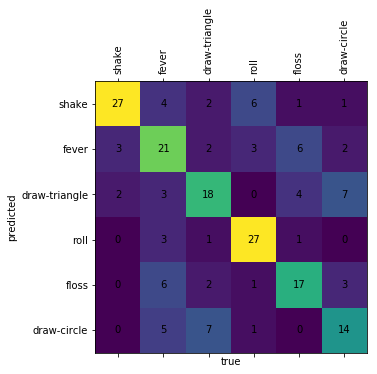

In [19]:
y_hat = model_1.predict(test_df.drop('label', axis=1))
y_hat = y_hat.argmax(axis=1)
y_hat = label_encoder.inverse_transform(y_hat)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot()

labels = list(test_df['label'].value_counts().index)

confusion = confusion_matrix(test_label, y_hat, labels=labels)
ax.matshow(confusion)

ax.set_xticks(range(len(labels)))
ax.set_yticks(range(len(labels)))

ax.set_xticklabels(labels, rotation=90);
ax.set_yticklabels(labels);

for i in range(len(labels)):
    for j in range(len(labels)):        
        ax.text(j, i, confusion[i,j], va='center', ha='center')
        
plt.xlabel('true')
plt.ylabel('predicted')

In [20]:
print(classification_report(test_label, y_hat, labels=labels))

               precision    recall  f1-score   support

        shake       0.84      0.66      0.74        41
        fever       0.50      0.57      0.53        37
draw-triangle       0.56      0.53      0.55        34
         roll       0.71      0.84      0.77        32
        floss       0.59      0.59      0.59        29
  draw-circle       0.52      0.52      0.52        27

    micro avg       0.62      0.62      0.62       200
    macro avg       0.62      0.62      0.62       200
 weighted avg       0.63      0.62      0.62       200



In [21]:
test_set = test_df.drop('label', axis=1)
y = test_df.label.values

In [22]:
def confident_evaluation(X,y,model,label_encoder, threshold):
    
    feature_vectors = X.values 
    probabilities = model.predict_proba(feature_vectors)
    probabilities = pd.DataFrame(np.exp(probabilities))
    
    max_probability = pd.Series(np.max(probabilities, axis=1))
    gesture = probabilities.idxmax(axis=1)
    confident = pd.Series(max_probability >= threshold)
    
    accuracy = []
    unkown = []
    
    for prediction in confident.index:
        
        if confident[prediction] == True:
            predicted_gesture = label_encoder.inverse_transform([gesture[prediction]])[0]
            if predicted_gesture == y[prediction]:
                accuracy.append(1)
            else:
                accuracy.append(0)

        else:
            unkown.append(1)
        

    print("\nNumber of confident gestures: ", len(accuracy))
    
    print("Confident accuracy: ", float(sum(accuracy))/len(accuracy))
    
    print("Number of unknown gestures: ", len(unkown))
    
    print("Model was not confident about", len(unkown)/len(y)*100, "percent of data")
        

In [23]:
confident_evaluation(test_df.drop('label',axis=1), y, model_1 ,label_encoder, 0.85)


Number of confident gestures:  144
Confident accuracy:  0.6944444444444444
Number of unknown gestures:  56
Model was not confident about 28.000000000000004 percent of data


In [24]:
# Save model for serving

In [25]:
import os
from pathlib import Path
from datetime import datetime as dt

save = False
ver = int(dt.now().timestamp())

if save:
    for fmt in ['pb', 'hdf5', 'json']:
        # save model as hdf5
        MODEL_DIR = f"models/{fmt}"
        export_path = Path(MODEL_DIR, str(ver))

        if fmt == 'pb':
            # simple_save can not handle existing repository
            !rm -r {export_path}

            # Inspired by https://www.tensorflow.org/serving/tutorials/Serving_REST_simple
            # to save model for TF-serving
            tf.saved_model.simple_save(
                tf.keras.backend.get_session(),
                str(export_path),
                inputs={'input_data': model.input},
                outputs={t.name:t for t in model.outputs})
            
        elif fmt == 'hdf5':
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            model_path = Path(export_path, 'saved_model.h5') 
            
            # hdf5
            model.save(model_path)
            
        else:
            # make sure directory exists
            os.makedirs(export_path, exist_ok=True)
            
            # json
            model_spec_path = Path(
                export_path, 'saved_model_spec.json'
            )
            model_weights_path = Path(
                export_path, 'checkpoint')
            
            model_spec_path.write_text(model.to_json(), encoding='utf-8')
            model.save_weights(str(model_weights_path))

        print('\nSaved model:')
        !ls -l {export_path}